In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
rng = np.random.default_rng()

# Selects top n inputs to neuron

In [2]:
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

# Initialize assembly parameters

In [3]:
n_in = 1000
n_neurons = 1000
cap_size = 100
sparsity = 0.1
n_rounds = 5
beta = 1e0

# Create random connections not on diagonal
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool)) 

W = np.ones((n_neurons, n_neurons)) * mask

# Normalize by column sum
W /= W.sum(axis=0)

# Why repeat?
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

# Initialize image distributions

Instead of parameterizing image distribution, we will need to VAEs or a large sample of images.

In [4]:
n_samples = n_neurons
halfspace = np.zeros(n_in)
halfspace[:cap_size] = 1 / np.sqrt(cap_size)

mean = halfspace.sum() * cap_size / n_in 
margin = 3
pos = np.zeros((n_samples, n_in))
neg = np.zeros((n_samples, n_in))

pos[:, n_in // 8 :] = rng.random((n_samples, n_in - n_in // 8)) < cap_size / n_in
neg[:, n_in // 8 :] = rng.random((n_samples, n_in - n_in // 8)) < cap_size / n_in
n_on_p = int(np.ceil((mean + margin) * np.sqrt(n_in / 8)))
n_on_n = int(np.floor((mean - margin) * np.sqrt(n_in / 8)))
for i in range(n_samples):
    pos[i, rng.choice(n_in // 8, size=n_on_p, replace=False)] = 1.
    if n_on_n > 0:
        neg[i, rng.choice(n_in // 8, size=n_on_n, replace=False)] = 1.

# Stimuli and Assembly time evolution

In [5]:
W = np.ones_like(W) * mask
A = np.ones_like(A) * mask_a
W /= W.sum(axis=0) # Weights the inter-assembly neuron connection
A /= A.sum(axis=0) # Weights the input stimuli that projects onto the assembly
activations = np.zeros((n_rounds, n_neurons)) # Time record of activations
act_h = np.zeros(n_neurons)
for j in range(n_rounds):
    input = pos[j]
    act_h_new = k_cap(act_h @ W + input @ A, cap_size) # Linear combination of inter-assembly firing and stimuli projection
    activations[j] = act_h_new.copy() # Update time record of activations
    A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta # Scale A up by plasticity parameter
    W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta # Scale W up by plasticity parameter
    act_h = act_h_new
A /= A.sum(axis=0) # Why is normalization outside of the for loop?
W /= W.sum(axis=0)

# Read outputs using k-cap

In [6]:
outputs = np.zeros((2, n_rounds+1, n_samples, n_neurons))
for i in range(n_rounds):
    outputs[0, i+1] = k_cap(outputs[0, i] @ W + pos @ A, cap_size)
    outputs[1, i+1] = k_cap(outputs[1, i] @ W + neg @ A, cap_size)

# Visualize Images

<IPython.core.display.Javascript object>


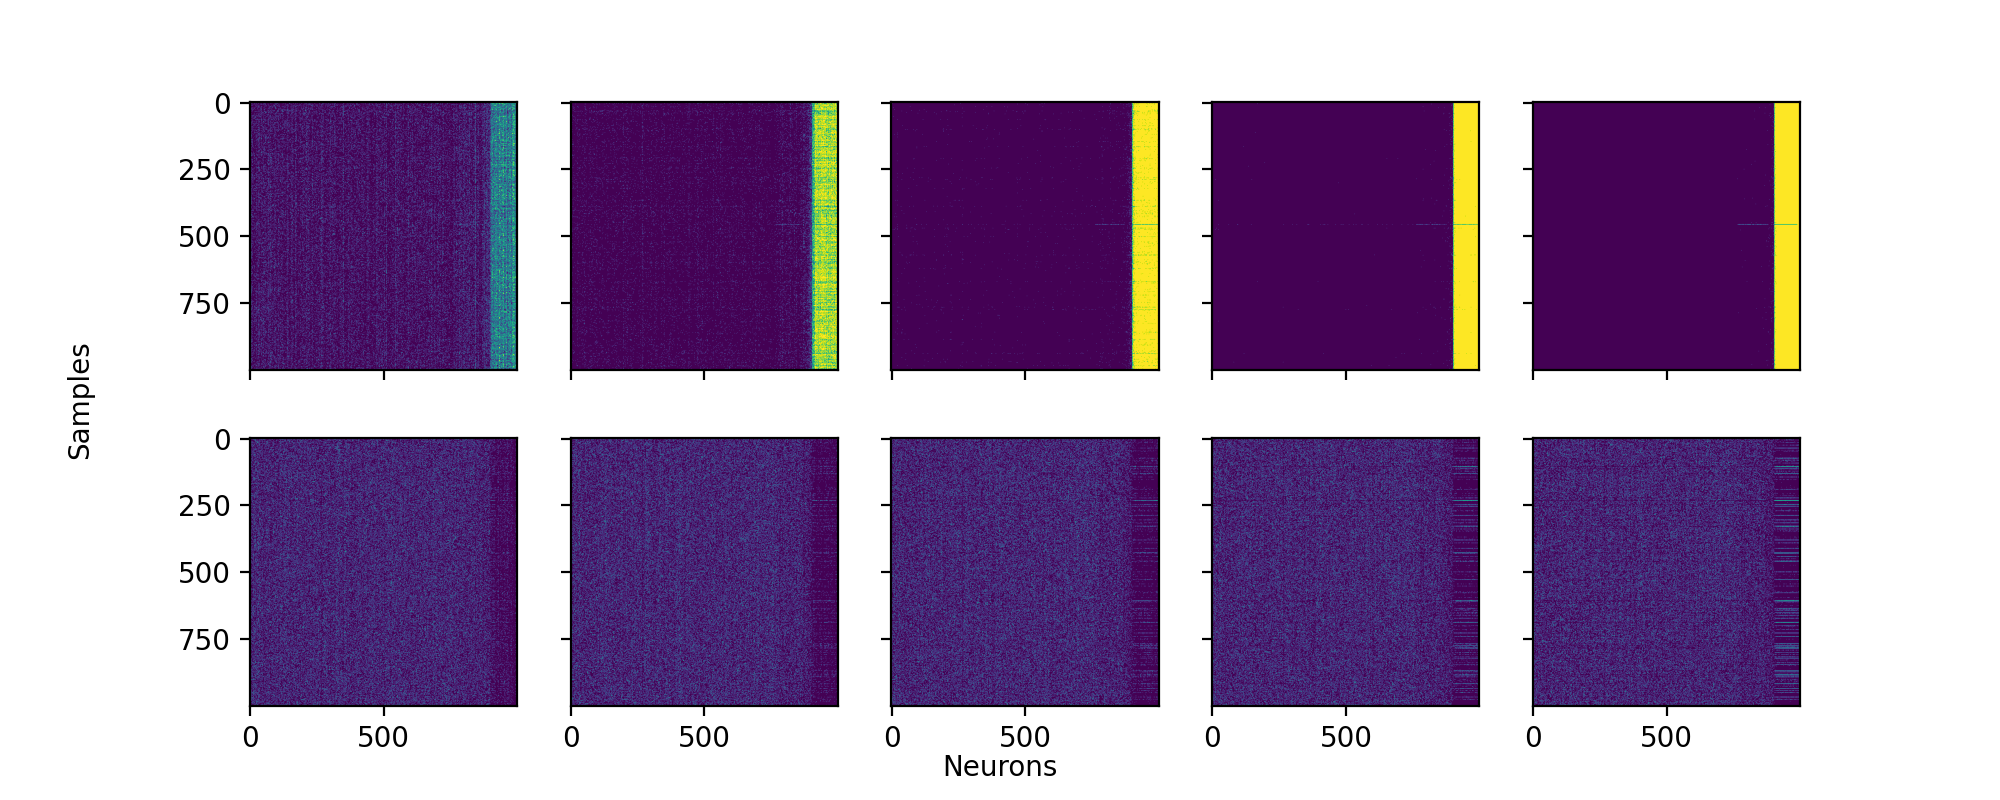

Text(0.04, 0.5, 'Samples')

In [7]:
idx = outputs[0, -1].sum(axis=0).argsort()
fig, axes = plt.subplots(2, n_rounds, figsize=(10, 2 * 2), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:, idx])
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

# Generate plots visualizing percentage of neurons belonging to "pixel core sets" of different classes

In [11]:
inp_overlap_mat = np.zeros((2, 2))
inp_overlap_mat[0, 0] = np.mean(np.sum(pos[:-1] * pos[1:], axis=-1))
inp_overlap_mat[0, 1] = np.mean(np.sum(pos[:-1] * neg[1:], axis=-1))
inp_overlap_mat[1, 0] = np.mean(np.sum(pos[:-1] * neg[1:], axis=-1))
inp_overlap_mat[1, 1] = np.mean(np.sum(neg[:-1] * neg[1:], axis=-1))

In [12]:
# Output array axes (class_label, n_rounds+1, n_samples, n_neurons)
# 0 for positive and 1 for negative
# outputs[0, -1][:-1] represents the last state in time evolution of all neurons that are positive samples for the 1st to the n_samples - 1 images in the positive sample set
# outputs[0, -1][1:] represents the last state in time evolution of all neurons that are positive samples for the 2nd to the n_samples images in the positive sample set
assm_overlap_mat = np.zeros((2, 2))

# Looks like 
assm_overlap_mat[0, 0] = np.mean(np.sum(outputs[0, -1][:-1] * outputs[0, -1][1:], axis=-1))
assm_overlap_mat[0, 1] = np.mean(np.sum(outputs[0, -1][:-1] * outputs[1, -1][1:], axis=-1))
assm_overlap_mat[1, 0] = np.mean(np.sum(outputs[1, -1][:-1] * outputs[0, -1][1:], axis=-1))
assm_overlap_mat[1, 1] = np.mean(np.sum(outputs[1, -1][:-1] * outputs[1, -1][1:], axis=-1))

<IPython.core.display.Javascript object>


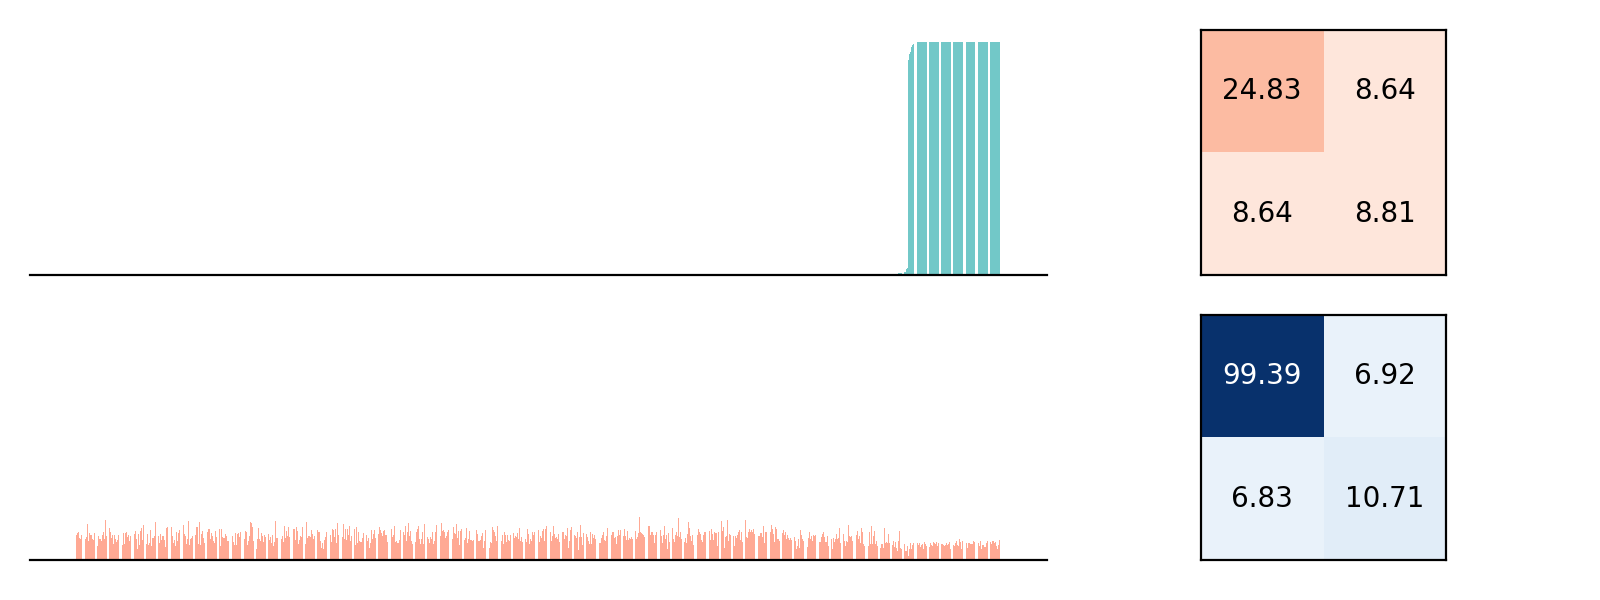

In [15]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8, 3))
gs = GridSpec(2, 3, figure=fig)
ax0 = plt.subplot(gs[0, :2])
ax0.set_xticks([])
ax0.set_yticks([])
axes = [ax0] + [plt.subplot(gs[i+1, :2], sharex=ax0, sharey=ax0) for i in range(1)]
colors = ['#72c8c8', '#ffa994']
for i in range(2):
    axes[i].bar(np.arange(n_neurons), outputs[i,-1].mean(axis=0)[idx], color=colors[i]) # Takes slice of ith class and last state of time evolution. Takes mean of neuron states over all samples.
    for side in ['top', 'right', 'left']:
        axes[i].spines[side].set_visible(False)
        
ax0 = plt.subplot(gs[0, -1])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(inp_overlap_mat, vmin=0, vmax=100, cmap='Reds')
for i in range(2):
    for j in range(2):
        ax0.text(j, i, np.round(inp_overlap_mat[i, j], 2), ha='center', va='center', c='k' if i == j else 'k')
ax = plt.subplot(gs[1, -1], sharex=ax0, sharey=ax0)
ax.imshow(assm_overlap_mat, vmin=0, vmax=100, cmap='Blues')
for i in range(2):
    for j in range(2):
        ax.text(j, i, np.round(assm_overlap_mat[i, j], 2), ha='center', va='center', c='w' if i == 0 and j == 0 else 'k')
    
fig.tight_layout()

# Mean neuron state at first round

<IPython.core.display.Javascript object>


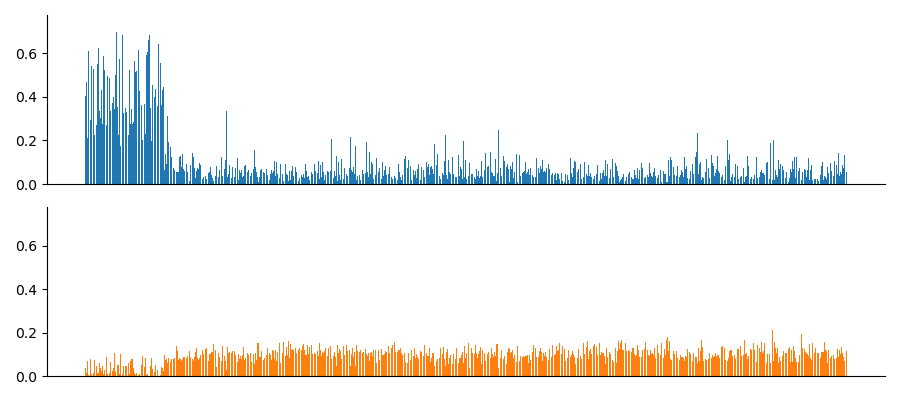

In [19]:
fig, axes = plt.subplots(2, figsize=(9, 4), sharex=True, sharey=True)
axes[0].bar(np.arange(999, -1, -1), np.mean(outputs[0, 1], axis=0)[idx], color='tab:blue')
axes[1].bar(np.arange(999, -1, -1), np.mean(outputs[1, 1], axis=0)[idx], color='tab:orange')
for ax in axes:
    ax.set_xticks([])
    for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
fig.tight_layout()

In [20]:
n_in = 1000
n_neurons = 1000
cap_size = 100
sparsity = 0.1
n_rounds = 5
beta = 1e0
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = (np.ones((n_neurons, n_neurons))) * mask
W /= W.sum(axis=0)
mask_a = (rng.random((n_in, n_neurons)) < sparsity)
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

# Testing performance over different margin values
Margin value is a specific feature of halfspace image classes. It parameterizes a distribution of images of class sets.

In [16]:
mean = (cap_size / n_in) * np.sqrt(cap_size)
margins = np.linspace(0, np.sqrt(cap_size) - mean, 20)

In [17]:
n_trials = 20
accs = np.zeros((20, n_trials))
for k, margin in enumerate(margins):
    for l in range(n_trials):
        pos = np.zeros((n_samples, n_in))
        neg = np.zeros((n_samples, n_in))
        pos[:, cap_size :] = rng.random((n_samples, n_in - cap_size)) < cap_size / n_in
        neg[:, cap_size :] = rng.random((n_samples, n_in - cap_size)) < cap_size / n_in
        n_on_p = int(np.ceil((mean + margin) * np.sqrt(cap_size)))
        n_on_n = int(np.floor((mean - margin) * np.sqrt(cap_size)))
        for i in range(n_samples):
            pos[i, rng.choice(cap_size, size=n_on_p, replace=False)] = 1.
            if n_on_n > 0:
                neg[i, rng.choice(cap_size, size=n_on_n, replace=False)] = 1.
        beta = 1.0
        W = np.ones_like(W) * mask
        A = np.ones_like(A) * mask_a
        W /= W.sum(axis=0)
        A /= A.sum(axis=0)
        activations = np.zeros((n_rounds, n_neurons))
        act_h = np.zeros(n_neurons)
        for j in range(n_rounds):
            input = pos[j]
            act_h_new = k_cap(act_h @ W + input @ A, cap_size)
            activations[j] = act_h_new.copy()
            A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
            act_h = act_h_new
        A /= A.sum(axis=0)
        W /= W.sum(axis=0)

        outputs = np.zeros((2, n_samples, n_neurons))
        outputs[0] = k_cap(pos @ A, cap_size)
        outputs[1] = k_cap(neg @ A, cap_size)
        c = np.full(n_neurons, 0)
        c[outputs[0].sum(axis=0).argsort()[-cap_size:]] = 1
        counts = np.count_nonzero((outputs @ c) > cap_size / 2, axis=-1)
        accs[k, l] = (counts[0] + 1000 - counts[1]) / 2000

<IPython.core.display.Javascript object>


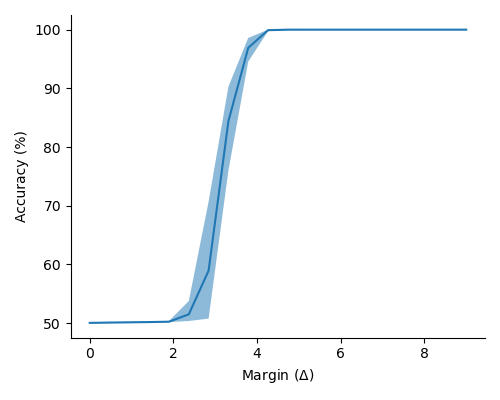

In [22]:
fig, ax = plt.subplots(figsize=(5,4))
mean = (cap_size / n_in) * np.sqrt(cap_size)
margins = np.linspace(0, np.sqrt(cap_size) - mean, 20)
ax.fill_between(margins, 100 * accs.min(axis=-1), 100 * accs.max(axis=-1), alpha=0.5)
ax.plot(margins, 100 * accs.mean(axis=-1))
ax.set_xlabel(r'Margin ($\Delta$)')
ax.set_ylabel('Accuracy (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()